# Using Deep Learning to Identify Images of Fruits

I will be using deep learning techniques via the Keras API to train a Convolutional Neural Network (CNN) model on a dataset of fruit images, and evaluate this model's accuracy on a separate test dataset of fruit images.

I will be focusing on optimizing my CNN model to give me the highest possible accuracy on both my training & test data.

## Importing Training & Test Images

In [2]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import skimage
from skimage import io, transform
from IPython.display import Image, display

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import LSTM, Input
from keras.models import Model
from keras.optimizers import Adam

img_size = 100
train_dir = './data/fruits/test/'
test_dir =  './data/fruits/train/'

def get_data(folder_path):
    imgs = []
    indices = []
    labels = []
    for idx, folder_name in enumerate(os.listdir(folder_path)[:10]):
        if not folder_name.startswith('.'):
            labels.append(folder_name)
            for file_name in tqdm(os.listdir(folder_path + folder_name)):
                if not file_name.startswith('.'):
                    img_file = io.imread(folder_path + folder_name + '/' + file_name)
                    if img_file is not None:
                        img_file = transform.resize(img_file, (img_size, img_size))
                        imgs.append(np.asarray(img_file))
                        indices.append(idx)
    imgs = np.asarray(imgs)
    indices = np.asarray(indices)
    labels = np.asarray(labels)
    return imgs, indices, labels

X_train, y_train, train_labels = get_data(train_dir)
X_test, y_test, test_labels = get_data(test_dir)

  0%|          | 0/166 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 490/490 [00:01<00:00, 346.45it/s]


## Data Wrangling

In [3]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train:', y_train)
print('y_test:', y_test)
# print('First image - X_train:', X_train[0])

num_categories = len(np.unique(y_train))

new_X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]).astype('float32')
new_X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]).astype('float32')
new_y_train = keras.utils.to_categorical(y_train, num_categories)
new_y_test = keras.utils.to_categorical(y_test, num_categories)

X_train shape: (1709, 100, 100, 3)
X_test shape: (5093, 100, 100, 3)
y_train: [0 0 0 ... 9 9 9]
y_test: [0 0 0 ... 9 9 9]


## Exploratory Data Analysis

In [4]:
def display_imgs(folder_path):
    for idx, folder_name in enumerate(os.listdir(folder_path)):
        if idx % 25 == 0:
            if not folder_name.startswith('.'):
                for idx2, file_name in enumerate(tqdm(os.listdir(folder_path + folder_name))):
                    if idx2 % 75 == 0:
                        if not file_name.startswith('.'):
                            img_filename = folder_path + folder_name + '/' + file_name
                            display(Image(filename=img_filename))

### Examples of Training Images

  0%|          | 0/166 [00:00<?, ?it/s]

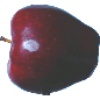

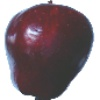

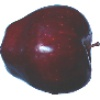

  0%|          | 0/164 [00:00<?, ?it/s]

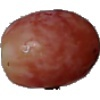

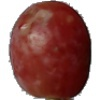

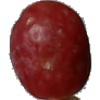

  0%|          | 0/166 [00:00<?, ?it/s]

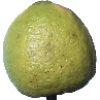

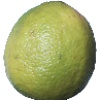

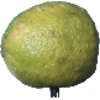

100%|██████████| 166/166 [00:00<00:00, 28611.24it/s]


In [5]:
display_imgs(train_dir)

### Examples of Test Images

  0%|          | 0/490 [00:00<?, ?it/s]

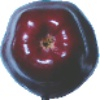

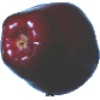

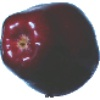

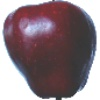

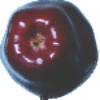

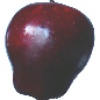

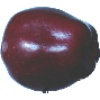

  0%|          | 0/492 [00:00<?, ?it/s]

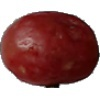

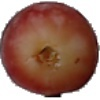

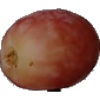

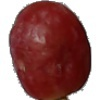

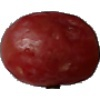

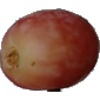

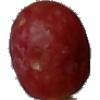

  0%|          | 0/490 [00:00<?, ?it/s]

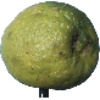

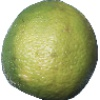

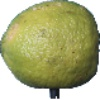

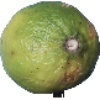

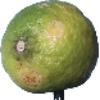

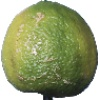

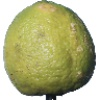

100%|██████████| 490/490 [00:00<00:00, 38272.05it/s]


In [6]:
display_imgs(test_dir)

## Initial Model Selection
### Convolutional Neural Network (CNN)

In [7]:
def evaluate_model(model, batch_size, epochs):
    history = model.fit(new_X_train, new_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(new_X_test, new_y_test))
    score = model.evaluate(new_X_test, new_y_test, verbose=0)
    print('***Metrics Names***', model.metrics_names)
    print('***Metrics Values***', score)

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.25))

convolutional.add(Flatten())
convolutional.add(Dense(128, activation='relu'))
convolutional.add(Dropout(0.5))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 128, 5)

From the above epochs, I can already see that my model is over-fitting on my training data from the 2nd epoch on – we can see that the model's testing accuracy is OVER 15% higher than its validation accuracy by the 3rd epoch. The highest validation accuracy comes at the 4th epoch (~81%), and drops in the subsequent epoch. 

Overall, my model is performing at ~81% accuracy at its best, but is drastically overfitting. I will now be attempting to optimize this model. 

## Optimizing the CNN Model
### Strategy 1 – Increase Dropout Rates to Counter Overfitting

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.6))

convolutional.add(Flatten())
convolutional.add(Dense(128, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 128, 7)

Increasing the dropout does help with overfitting – it doesn't overfit until the 3rd epoch, and even then by a smaller percentage, but that overfit percentage does go back up by the 4th and 5th epoch. 

Overall, this model seems to have a better performance than my initial model, hovering at ~84% validation accuracy at its best, with less overfitting.

### Strategy 2 – Use Different Loss Functions [Not Successful]

In [ ]:
def run_with_loss(loss):
    convolutional = Sequential()

    convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
    convolutional.add(Conv2D(64, (3, 3), activation='relu'))
    convolutional.add(MaxPooling2D(pool_size=(2, 2)))
    convolutional.add(Dropout(0.6))

    convolutional.add(Flatten())
    convolutional.add(Dense(128, activation='relu'))
    convolutional.add(Dropout(0.6))
    convolutional.add(Dense(num_categories, activation='softmax'))

    convolutional.summary()
    convolutional.compile(loss=loss, optimizer=Adam(), metrics=['accuracy'])

    evaluate_model(convolutional, 128, 5)

losses = ['mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error']

for loss in losses:
    run_with_loss(loss)

None of these other loss functions show a significant improvement over the original loss function of 'categorical_crossentropy'. Of the 3 attempted, 'mean_squared_error' performed the best, coming in with a validation accuracy of ~73% before overfitting.

### Strategy 3 – Add More Convolutional Layers [Successful]

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 128, 5)

This model is still overfitting from the 3rd epoch onwards, but I am getting a slightly better performance with best validation accuracy of ~85%.

### Strategy 4 – Decrease Batch Size [Successful]

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

This is yielding better performance – it is still slightly overfitting from the 3rd epoch on, but validation accuracy is hovering at ~85%, with a max of ~87%. 

### Strategy 5 – Decrease Kernel Size [Not Successful]

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(2,2), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (2, 2), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(2,2), activation='relu'))
convolutional.add(Conv2D(256, (2, 2), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

Decreasing kernel size doesn't yield any significant improvements – if anything, it causes the model to overfit earlier and to reach a slightly lower maximum validation accuracy (~85%). 

### Strategy 6 – Decrease Learning Rate [Successful]

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(lr=.0005), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

Decreasing the learning rate resulted in slightly higher accuracy rates, though it did slightly increase the runtime of the model. I will be keeping this lower learning rate, as I don't believe the speed decrease was significant enough to be a detriment to the model.

## Finalizing Model

Combine all successful optimizing strategies (additional convolutional layers, increased dropout rates, decreased batch size, etc.), alongside Batch Normalization, for a final optimized model.

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(BatchNormalization())
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(lr=.0005), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

### Evaluating Finalized Model

In [ ]:
y_pred = convolutional.predict(new_X_test, batch_size=None, verbose=0, steps=None).argmax(axis=-1)
res_crosstab = pd.crosstab(y_pred, y_test)

dict_idx_fruit = {idx: label for idx, label in enumerate(test_labels)}
print(dict_idx_fruit)

res_crosstab

In [ ]:
for idx in range(num_categories):
    accuracy = res_crosstab.loc[idx, idx] / res_crosstab.loc[:, idx].sum()
    flag = '***LOW***' if accuracy < 0.8 else ''
    print(dict_idx_fruit[idx])
    print('   ', flag, 'accuracy –', round(accuracy * 100, 2), '%')

## Running Final Model On More Data

In [1]:
# Run on Kaggle with GPU 

img_size = 100
train_dir = '../input/fruits-360_dataset/fruits-360/Test/'
test_dir =  '../input/fruits-360_dataset/fruits-360/Training/'

def get_data(folder_path):
    imgs = []
    indices = []
    labels = []
    for idx, folder_name in enumerate(os.listdir(folder_path)[:35]):
        if not folder_name.startswith('.'):
            labels.append(folder_name)
            for file_name in tqdm(os.listdir(folder_path + folder_name)):
                if not file_name.startswith('.'):
                    img_file = io.imread(folder_path + folder_name + '/' + file_name)
                    if img_file is not None:
                        img_file = transform.resize(img_file, (img_size, img_size))
                        imgs.append(np.asarray(img_file))
                        indices.append(idx)
    imgs = np.asarray(imgs)
    indices = np.asarray(indices)
    labels = np.asarray(labels)
    return imgs, indices, labels

X_train, y_train, train_labels = get_data(train_dir)
X_test, y_test, test_labels = get_data(test_dir)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
  0%|          | 0/164 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 490/490 [00:01<00:00, 304.44it/s]


In [2]:
num_categories = len(np.unique(y_train))

new_X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]).astype('float32')
new_X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]).astype('float32')
new_y_train = keras.utils.to_categorical(y_train, num_categories)
new_y_test = keras.utils.to_categorical(y_test, num_categories)

In [5]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(BatchNormalization())
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(lr=.0005), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 256)       295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 256)       0         
__________

In [6]:
y_pred = convolutional.predict(new_X_test, batch_size=None, verbose=0, steps=None).argmax(axis=-1)
res_crosstab = pd.crosstab(y_pred, y_test)

dict_idx_fruit = {idx: label for idx, label in enumerate(test_labels)}
print(dict_idx_fruit)

res_crosstab

{0: 'Nectarine', 1: 'Kaki', 2: 'Avocado', 3: 'Apple Golden 3', 4: 'Lemon', 5: 'Pear Monster', 6: 'Apple Red Yellow', 7: 'Cherry 2', 8: 'Apple Red 1', 9: 'Pear Abate', 10: 'Mandarine', 11: 'Strawberry', 12: 'Cherry Rainier', 13: 'Cocos', 14: 'Cantaloupe 2', 15: 'Granadilla', 16: 'Pomegranate', 17: 'Lychee', 18: 'Quince', 19: 'Raspberry', 20: 'Tangelo', 21: 'Mango', 22: 'Plum', 23: 'Tamarillo', 24: 'Apple Granny Smith', 25: 'Tomato Maroon', 26: 'Passion Fruit', 27: 'Lemon Meyer', 28: 'Grapefruit White', 29: 'Banana Red', 30: 'Huckleberry', 31: 'Cherry Wax Yellow', 32: 'Physalis with Husk', 33: 'Dates', 34: 'Clementine'}


col_0,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
row_0,,,,,,,,,,,,,,,,,,,,,
0,227,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,421,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,427,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,371,0,75,99,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,490,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,401,0,0,0,0,...,0,0,0,0,0,0,0,23,0,0
6,97,0,0,0,0,0,363,0,2,0,...,0,0,0,0,0,0,0,0,0,0
7,13,0,0,0,0,0,0,708,3,0,...,0,0,0,0,23,0,0,0,0,0
8,131,56,0,0,0,0,30,0,469,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
for idx in range(num_categories):
    accuracy = res_crosstab.loc[idx, idx] / res_crosstab.loc[:, idx].sum()
    flag = '***LOW***' if accuracy < 0.75 else ''
    print(dict_idx_fruit[idx])
    print('   ', flag, 'accuracy –', round(accuracy * 100, 2), '%')

Nectarine
    ***LOW*** accuracy – 46.14 %
Kaki
     accuracy – 85.92 %
Avocado
     accuracy – 100.0 %
Apple Golden 3
     accuracy – 77.13 %
Lemon
     accuracy – 99.59 %
Pear Monster
     accuracy – 81.84 %
Apple Red Yellow
    ***LOW*** accuracy – 73.78 %
Cherry 2
     accuracy – 95.93 %
Apple Red 1
     accuracy – 95.33 %
Pear Abate
     accuracy – 92.65 %
Mandarine
     accuracy – 100.0 %
Strawberry
    ***LOW*** accuracy – 73.58 %
Cherry Rainier
     accuracy – 80.76 %
Cocos
     accuracy – 100.0 %
Cantaloupe 2
     accuracy – 100.0 %
Granadilla
    ***LOW*** accuracy – 72.65 %
Pomegranate
     accuracy – 91.46 %
Lychee
     accuracy – 92.24 %
Quince
     accuracy – 100.0 %
Raspberry
     accuracy – 100.0 %
Tangelo
     accuracy – 100.0 %
Mango
     accuracy – 100.0 %
Plum
     accuracy – 100.0 %
Tamarillo
     accuracy – 77.14 %
Apple Granny Smith
     accuracy – 100.0 %
Tomato Maroon
     accuracy – 100.0 %
Passion Fruit
     accuracy – 100.0 %
Lemon Meyer
     accuracy – 100.

## Conclusion

The final CNN model is performing ~10% better than the initial model, with a validation accuracy of 91% and training accuracy of 100%. There is slight overfitting (9%), but much less than in the original model.

Looking at the crosstab by category, it is obvious that most fruits are being predicted accurately, with a handful (e.g. nectarines, granadillas) that are more difficult to distinguish and thus bringing the accuracy of the overall model down. In the future, we could add more images to train on pairs of fruits that are being mistaken for each other (i.e. nectarines vs. apple red 1s, apple golden 3s vs. apple granny smiths, etc.).

Could also do TensorBoard visualizations to visualize model performance, but Kaggle GPU was limiting factor in this realm.